# Summary:
This notebook will cover exploratory data analysis (EDA) of the text file.

# Table of contents
* [1. Exploratory data analysis](#Part1_link)
<br >&nbsp;&nbsp;&nbsp;[1.1 Data cleaning](#Part1.1_link)
<br >&nbsp;&nbsp;&nbsp;[1.2 Number of descriptions in each class](#Part1.2_link)
<br >&nbsp;&nbsp;&nbsp;[1.3 Text length](#Part1.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.3.1 Number of sentences and number of words in each text for training dataset across 9 classes](#Part1.3.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.3.2 Compare number of sentences and number of words between training and testing datasets](#Part1.3.2_link)
<br >&nbsp;&nbsp;&nbsp;[1.4 Gene and Variation](#Part1.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.4.1 Gene](#Part1.4.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.4.2 Gene variation](#Part1.4.2_link)
<br >&nbsp;&nbsp;&nbsp;[1.5 Most mutated genes for each class](#Part1.5_link)
<br >&nbsp;&nbsp;&nbsp;[1.6 Keywords](#Part1.6_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.6.1 Extract keywords using `gensim.summarization.keywords` for training and testing datasets](#Part1.6.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.6.2 Extract keywords from each class](#Part1.6.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.6.3 Visualize frequent words in each category after removing custom words](#Part1.6.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.6.4 Visualize frequent words in each category using WordCloud](#Part1.6.4_link)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib_venn import venn2
from collections import Counter
from collections import defaultdict

import gensim
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
from matplotlib_venn import venn2
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from ast import literal_eval

<a id='Part1_link'></a>
# 1. Exploratory data analysis

Both training and test datasets are provided via two files, `training_text/training_variants` and `test_text/test_variants`, linked the unique ID field.

In [2]:
base_dir='/Volumes/Yuchen_Drive/Personalized_Medicine'

In [3]:
train_text_df=pd.read_csv(os.path.join(base_dir, 'training_text'), sep='\|\|', header=None, skiprows=1, names=['ID', 'Text'])
train_variant_df=pd.read_csv(os.path.join(base_dir, 'training_variants'))
train_df=pd.merge(train_text_df, train_variant_df, left_on='ID', right_on='ID')
train_df.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,ID,Text,Gene,Variation,Class
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4


In [4]:
test_text_df=pd.read_csv(os.path.join(base_dir, 'test_text'), sep='\|\|', header=None, skiprows=1, names=['ID', 'Text'])
test_variant_df=pd.read_csv(os.path.join(base_dir, 'test_variants'))
test_df=pd.merge(test_text_df, test_variant_df, left_on='ID', right_on='ID')
test_df.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,ID,Text,Gene,Variation
0,0,2. This mutation resulted in a myeloproliferat...,ACSL4,R570S
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...,NAGLU,P521L
2,2,Vascular endothelial growth factor receptor (V...,PAH,L333F
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...,ING1,A148D
4,4,Abstract Retinoblastoma is a pediatric retina...,TMEM216,G77A


<a id='Part1.1_link'></a>
## 1.1 Data cleaning

In [15]:
train_df.isnull().sum()

ID           0
Text         5
Gene         0
Variation    0
Class        0
dtype: int64

In [16]:
test_df.isnull().sum()

ID           0
Text         1
Gene         0
Variation    0
dtype: int64

In [17]:
train_df[train_df.Text.isnull()]

,ID,Text,Gene,Variation,Class
1109,1109,NaN,FANCA,S1088F,1
1277,1277,NaN,ARID5B,Truncating Mutations,1
1407,1407,NaN,FGFR3,K508M,6
1639,1639,NaN,FLT1,Amplification,6
2755,2755,NaN,BRAF,G596C,7


In [18]:
test_df[test_df.Text.isnull()]

,ID,Text,Gene,Variation
1623,1623,NaN,AURKB,Amplification


`NaN` in text cannot provide any insight into classification. Thus, rows with `NaN` in `Text` field need to be removed.

In [5]:
print('Number of rows in train_df before filtering NA: {}'.format(train_df.shape[0]))
train_df=train_df[-train_df.Text.isnull()]
print('Number of rows in train_df after filtering NA: {}'.format(train_df.shape[0]))

Number of rows in train_df before filtering NA: 3321
Number of rows in train_df after filtering NA: 3316


In [6]:
print('Number of rows in test_df before filtering NA: {}'.format(test_df.shape[0]))
test_df=test_df[-test_df.Text.isnull()]
print('Number of rows in test_df after filtering NA: {}'.format(test_df.shape[0]))

Number of rows in test_df before filtering NA: 5668
Number of rows in test_df after filtering NA: 5667


In [21]:
train_df.describe(include='all')

,ID,Text,Gene,Variation,Class
count,3316.000000,3316,3316,3316,3316.000000
unique,NaN,1920,262,2993,NaN
top,NaN,The PTEN (phosphatase and tensin homolog) phos...,BRCA1,Truncating Mutations,NaN
freq,NaN,53,264,92,NaN
mean,1660.034077,NaN,NaN,NaN,4.366104
std,959.287860,NaN,NaN,NaN,2.309241
min,0.000000,NaN,NaN,NaN,1.000000
25%,828.750000,NaN,NaN,NaN,2.000000
50%,1661.500000,NaN,NaN,NaN,4.000000
75%,2490.250000,NaN,NaN,NaN,7.000000


In [22]:
test_df.describe(include='all')

,ID,Text,Gene,Variation
count,5667.000000,5667,5667,5667
unique,NaN,5610,1396,5628
top,NaN,The PTEN (phosphatase and tensin homolog) phos...,F8,Truncating Mutations
freq,NaN,6,134,18
mean,2833.713605,NaN,NaN,NaN
std,1636.420359,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,1416.500000,NaN,NaN,NaN
50%,2834.000000,NaN,NaN,NaN
75%,4250.500000,NaN,NaN,NaN


<a id='Part1.2_link'></a>
## 1.2 Number of descriptions in each class

In [25]:
print('Number of unique classes: {}'.format(train_df.Class.nunique()))
print(train_df.Class.unique())

Number of unique classes: 9
[1 2 3 4 5 6 7 8 9]


In [27]:
train_class=train_df.Class.value_counts().to_frame().reset_index().rename(columns={'Class':'counts', 'index':'Class'}).sort_values(by=['Class'])
train_class

,Class,counts
2,1,566
3,2,452
6,3,89
1,4,686
5,5,242
4,6,273
0,7,952
8,8,19
7,9,37


Text(0.5, 1.0, 'Number of descriptions in each class')

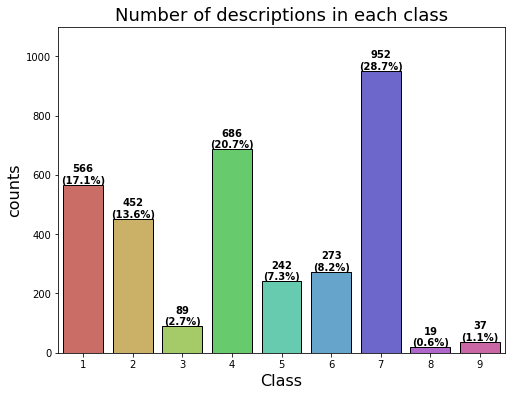

In [35]:
palette=sns.color_palette('hls',len(train_class))
fig,ax=plt.subplots(1,1,figsize=(8,6))
sns.barplot(x='Class', y='counts', data=train_class,palette=palette,edgecolor='black')
for i,h in enumerate(train_class.counts):
    ax.text(i,h+5,'{}\n({:.1f}%)'.format(str(h),h/train_class.counts.sum()*100),fontweight='bold',fontsize=10,ha = 'center')
ax.set_xlabel('Class', fontsize=16)
ax.set_ylabel('counts', fontsize=16)
ax.set_ylim(0,1100)
ax.set_title('Number of descriptions in each class',fontsize=18)

There are 9 classes of genetic mutations in this project. As we can see from the above barplot, the distribution of data is imbalanced. `Class7` and `Class4` account for almost 50% of the entire dataset, while `Class3`, `Class8` and `Class9` have very few descriptions. The imbalance in data distribution needs to be considered when we split datasets as well as train the classification model.

<a id='Part1.3_link'></a>
## 1.3 Text length

<a id='Part1.3.1_link'></a>
### 1.3.1 Number of sentences and number of words in each text for training dataset across 9 classes

Each text (description of genetic mutations) contains multiple sentences and each sentence contains multiple words. As part of EDA, we will analyze the number of sentences as well as text length (number of words) for each description and compare the differences in sentence/word length distribution across the 9 classes.

In [52]:
train_df['sent_length']=train_df.Text.apply(lambda x:len(sent_tokenize(x)))
train_df['word_length']=train_df.Text.apply(lambda x:len([word for sent in sent_tokenize(x) for word in word_tokenize(sent)]))

In [55]:
train_df.head()

,ID,Text,Gene,Variation,Class,sent_length,word_length
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1,326,7313
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2,248,6784
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2,248,6784
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3,185,6396
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4,262,7248


Text(0, 0.5, 'Density')

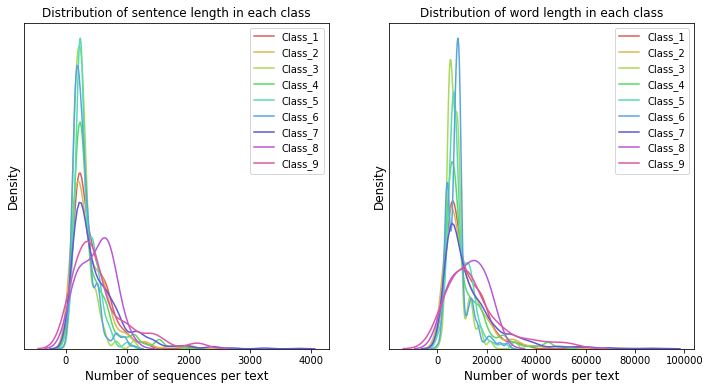

In [72]:
fig,axes=plt.subplots(1,2,figsize=(12,6))
for i in range(1,10):
    sns.distplot(train_df[train_df.Class==i].sent_length,color=palette[i-1],hist=False,ax=axes[0],label='Class_{}'.format(i))
    sns.distplot(train_df[train_df.Class==i].word_length,color=palette[i-1],hist=False,ax=axes[1],label='Class_{}'.format(i))
axes[0].set_title('Distribution of sentence length in each class',fontsize=12)
axes[0].set_xlabel('Number of sequences per text', fontsize=12)
axes[0].set_yticks([])
axes[0].set_ylabel('Density',fontsize=12)
axes[1].set_title('Distribution of word length in each class',fontsize=12)
axes[1].set_xlabel('Number of words per text', fontsize=12)
axes[1].set_yticks([])
axes[1].set_ylabel('Density',fontsize=12)

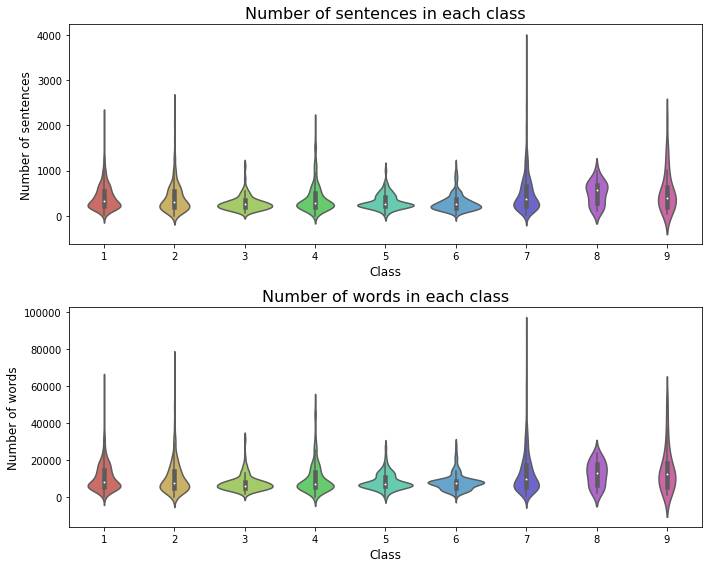

In [80]:
fig,axes=plt.subplots(2,1,figsize=(10,8))
sns.violinplot(x='Class',y='sent_length',data=train_df,palette=palette,ax=axes[0])
sns.violinplot(x='Class',y='word_length',data=train_df,palette=palette,ax=axes[1])
axes[0].set_title('Number of sentences in each class',fontsize=16)
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Number of sentences',fontsize=12)
axes[1].set_title('Number of words in each class',fontsize=16)
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Number of words',fontsize=12)
plt.tight_layout()

Text(0, 0.5, 'Number of words')

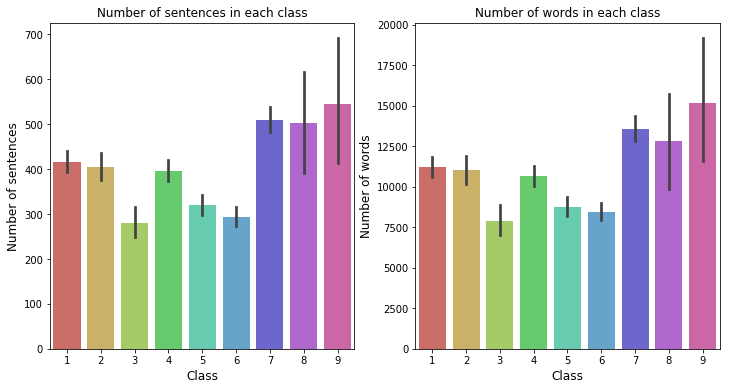

In [65]:
fig,axes=plt.subplots(1,2,figsize=(12,6))
sns.barplot(x='Class',y='sent_length',data=train_df,palette=palette,ax=axes[0])
sns.barplot(x='Class',y='word_length',data=train_df,palette=palette,ax=axes[1])
axes[0].set_title('Number of sentences in each class',fontsize=12)
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Number of sentences',fontsize=12)
axes[1].set_title('Number of words in each class',fontsize=12)
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Number of words',fontsize=12)

In [59]:
sent_word_summary_df=train_df.groupby(['Class']).agg({'sent_length':{'max_length':np.max,'min_length':np.min,'mean_length':np.mean,'median_length':np.median}, 'word_length':{'max_length':np.max,'min_length':np.min,'mean_length':np.mean,'median_length':np.median,'counts':lambda x:len(x)}})
sent_word_summary_df.columns=['sent_len_max','sent_len_min','sent_len_mean','sent_len_median','word_len_max','word_len_min','word_len_mean','word_len_median','counts']
sent_word_summary_df

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,sent_len_max,sent_len_min,sent_len_mean,sent_len_median,word_len_max,word_len_min,word_len_mean,word_len_median,counts
Class,,,,,,,,,
1,2191,7,416.355124,335.0,62425,200,11189.339223,8591,566
2,2491,5,404.834071,306.5,73709,144,11034.964602,8062,452
3,1105,70,280.820225,253.0,31506,2084,7902.629213,6423,89
4,2065,3,396.103499,291.0,51268,58,10634.103499,7501,686
5,1062,7,319.148760,257.0,27964,200,8760.260331,7358,242
6,1116,10,293.996337,257.0,28592,258,8447.098901,7543,273
7,3784,14,510.266807,364.0,91372,531,13569.669118,9749,952
8,988,114,501.947368,564.0,23797,2482,12799.157895,13154,19
9,2137,42,544.270270,393.0,53607,1378,15155.081081,12853,37


Based on density plot, violinplot, barplot and summary table, the number of sentences and number of words in texts for each class have distinct distributions, especially for `Class8` and `Class9`. Considering the small dataset for `Class8` and `Class9`, this may be due to the small sample size.

<a id='Part1.3.2_link'></a>
### 1.3.2 Compare number of sentences and number of words between training and testing datasets

Descriptions for different classes have slightly different length distributions, implying that sentence_length/word_length may contribute to classification results. This suggests that we also need to compare the sentence_length/word_length between training and testing datasets to avoid any potential bias and achieve the best classification results. 

In [66]:
test_df['sent_length']=test_df.Text.apply(lambda x:len(sent_tokenize(x)))
test_df['word_length']=test_df.Text.apply(lambda x:len([word for sent in sent_tokenize(x) for word in word_tokenize(sent)]))

In [67]:
test_df.head()

,ID,Text,Gene,Variation,sent_length,word_length
0,0,2. This mutation resulted in a myeloproliferat...,ACSL4,R570S,297,8492
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...,NAGLU,P521L,210,5561
2,2,Vascular endothelial growth factor receptor (V...,PAH,L333F,501,12971
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...,ING1,A148D,351,9563
4,4,Abstract Retinoblastoma is a pediatric retina...,TMEM216,G77A,437,13221


Text(0, 0.5, 'Density')

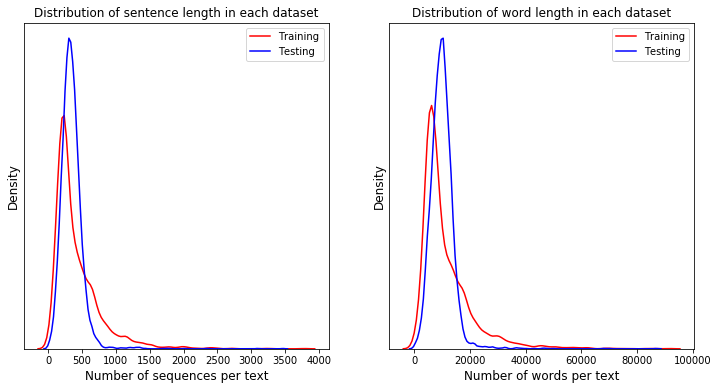

In [73]:
fig,axes=plt.subplots(1,2,figsize=(12,6))
sns.distplot(train_df.sent_length,color='red',hist=False,ax=axes[0],label='Training')
sns.distplot(test_df.sent_length,color='blue',hist=False,ax=axes[0],label='Testing')
axes[0].set_title('Distribution of sentence length in each dataset',fontsize=12)
axes[0].set_xlabel('Number of sequences per text', fontsize=12)
axes[0].set_yticks([])
axes[0].set_ylabel('Density',fontsize=12)

sns.distplot(train_df.word_length,color='red',hist=False,ax=axes[1],label='Training')
sns.distplot(test_df.word_length,color='blue',hist=False,ax=axes[1],label='Testing')
axes[1].set_title('Distribution of word length in each dataset',fontsize=12)
axes[1].set_xlabel('Number of words per text', fontsize=12)
axes[1].set_yticks([])
axes[1].set_ylabel('Density',fontsize=12)

The distribution of sentence_length/word_length is different between training and testing datasets. According to kaggle, some of the samples in the test data are machine-generated, which may cause the difference in distribution patterns. However, we need to be careful of the observed difference in text length, as this may lead to under-performance of the model when applied to the test dataset.

<a id='Part1.4_link'></a>
## 1.4 Gene and Variation

<a id='Part1.4.1_link'></a>
### 1.4.1 Gene

In [82]:
train_gene=train_df.Gene.unique()
test_gene=test_df.Gene.unique()
print('Number of unique genes in train_df: {}'.format(len(train_gene)))
print('Number of unique genes in test_df: {}'.format(len(test_gene)))

Number of unique genes in train_df: 262
Number of unique genes in test_df: 1396


In [290]:
gene_intersect=np.intersect1d(train_gene,test_gene)
print('Number of unique genes in both train_df and test_df: {}'.format(len(gene_intersect)))

Number of unique genes in both train_df and test_df: 153


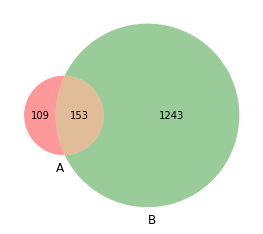

In [85]:
venn2([set(train_gene), set(test_gene)])

The majority of genes in the testing dataset are not involved in the training dataset, which may adds more difficulty to the classification. It also suggests that the `Gene` column is of less importance to the classification.

In [95]:
train_gene_freq=train_df.Gene.value_counts().reset_index().rename(columns={'Gene':'counts','index':'Gene'}).sort_values(by=['counts'],ascending=False)
train_gene_freq.head()

,Gene,counts
0,BRCA1,264
1,TP53,163
2,EGFR,141
3,PTEN,126
4,BRCA2,125


In [96]:
test_gene_freq=test_df.Gene.value_counts().reset_index().rename(columns={'Gene':'counts','index':'Gene'}).sort_values(by=['counts'],ascending=False)
test_gene_freq.head()

,Gene,counts
0,F8,134
1,CFTR,57
2,F9,54
3,G6PD,46
4,GBA,39


View the top mutated genes with the highest number of descriptions in each dataset.

Text(0.5, 1.0, 'Top 20 frequently mutated genes in testing dataset')

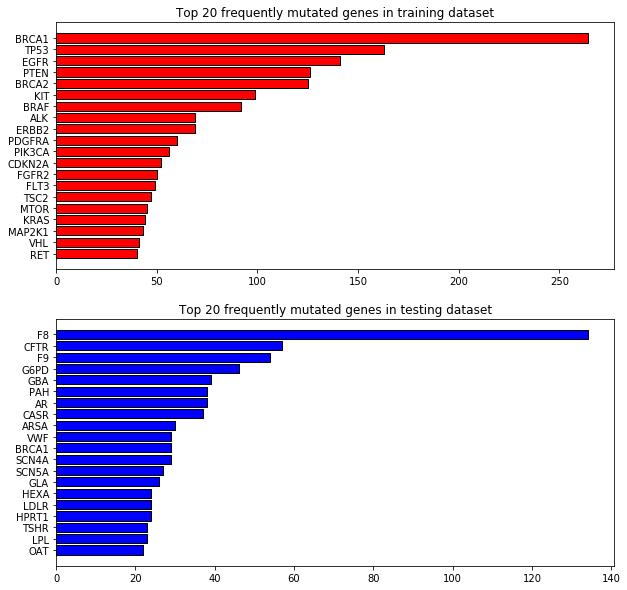

In [167]:
fig,axes=plt.subplots(2,1,figsize=(10,10))
axes[0].barh(np.arange(20),train_gene_freq.counts[:20],edgecolor='black',color='red')
axes[1].barh(np.arange(20),test_gene_freq.counts[:20],edgecolor='black',color='blue')

axes[0].set_yticks(np.arange(20))
axes[0].set_yticklabels(train_gene_freq.Gene[:20])
axes[0].invert_yaxis()
axes[0].set_title('Top 20 frequently mutated genes in training dataset')
axes[1].set_yticks(np.arange(20))
axes[1].set_yticklabels(test_gene_freq.Gene[:20])
axes[1].invert_yaxis()
axes[1].set_title('Top 20 frequently mutated genes in testing dataset')

In [187]:
np.intersect1d(train_gene_freq.Gene[:20].values, test_gene_freq.Gene[:20].values)

array(['BRCA1'], dtype=object)

The top 20 most frequently mutated genes are different in training and testing datasets. Only 1 gene `BRCA1` overlap in both training and testing datasets.

Text(0, 0.5, 'Density')

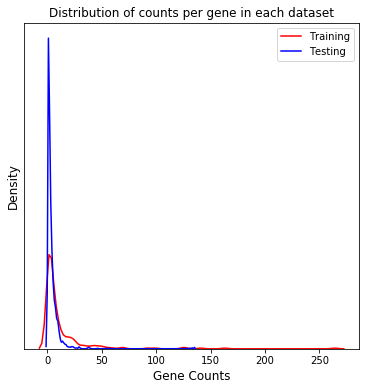

In [93]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
sns.distplot(train_gene_freq.counts,color='red',hist=False,ax=ax,label='Training')
sns.distplot(test_gene_freq.counts,color='blue',hist=False,ax=ax,label='Testing')
ax.set_title('Distribution of counts per gene in each dataset',fontsize=12)
ax.set_xlabel('Gene Counts', fontsize=12)
ax.set_yticks([])
ax.set_ylabel('Density',fontsize=12)

<a id='Part1.4.2_link'></a>
### 1.4.2 Gene variation

Variation refers to the amino acid change associated with the specific mutation.

In [107]:
train_variation=train_df.Variation.unique()
test_variation=test_df.Variation.unique()
print('Number of unique variation in train_df: {}'.format(len(train_variation)))
print('Number of unique variation in test_df: {}'.format(len(test_variation)))

Number of unique variation in train_df: 2993
Number of unique variation in test_df: 5628


In [109]:
variation_intersect1d=np.intersect1d(train_variation,test_variation)
print('Number of unique variation in both train_df and test_df: {}'.format(len(variation_intersect1d)))
print(variation_intersect1d)

Number of unique variation in both train_df and test_df: 15
['A59G' 'Amplification' 'D32Y' 'Deletion' 'EWSR1-ERG Fusion' 'Fusions'
 'G12C' 'G12D' 'G12R' 'G13D' 'G35V' 'Q61R' 'R183Q' 'TMPRSS2-ERG Fusion'
 'Truncating Mutations']


In [117]:
train_variation_freq=train_df.Variation.value_counts().reset_index().rename(columns={'Variation':'counts','index':'Variation'}).sort_values(by=['counts'],ascending=False)
print('Number of variation with more than 1 description: {}'.format(sum(train_variation_freq.counts>1)))
train_variation_freq.head(n=10)

Number of variation with more than 1 description: 50


,Variation,counts
0,Truncating Mutations,92
1,Deletion,74
2,Amplification,70
3,Fusions,34
4,Overexpression,6
5,G12V,4
8,T58I,3
9,Q61H,3
10,Q61R,3
7,Q61L,3


In [163]:
test_variation_freq=test_df.Variation.value_counts().reset_index().rename(columns={'Variation':'counts','index':'Variation'}).sort_values(by=['counts'],ascending=False)
print('Number of variation with more than 1 description: {}'.format(sum(test_variation_freq.counts>1)))
test_variation_freq.head(n=10)

Number of variation with more than 1 description: 5


,Variation,counts
0,Truncating Mutations,18
1,Deletion,14
2,Amplification,7
3,Fusions,3
4,G44D,2
3750,S318R,1
3758,G1586R,1
3757,R200A,1
3756,I393T,1
3755,R226Q,1


The annotation of variation is a little bit ambiguous here. `Truncating Mutations`, `Deletion`, `Amplification` and `Fusions` are all different types of genetic mutations and they are broad categories, similar to `Missense mutations`, which changes nucleotide in the codon and leads to a different amino acid. However, all the `Missense mutations` are presented in the format of substitution in amino acid in a specific position. One reason is that it is difficult to specify the other types of mutations in the protein/amion acid level. Since the annotation of variation is not in the same level, the information we can obtain from this field is also limited.   

In [146]:
train_gene_variation=train_df.groupby(['Gene']).agg({'Variation':{'unique_variation':lambda x:len(np.unique(x))}}).reset_index()
train_gene_variation.columns=['Gene','variation_count']
train_gene_variation=train_gene_variation.sort_values(by=['variation_count'],ascending=False)
train_gene_variation.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,Gene,variation_count
30,BRCA1,264
250,TP53,163
65,EGFR,141
194,PTEN,126
31,BRCA2,125


In [147]:
train_gene_variation=pd.merge(train_gene_variation,train_gene_freq,left_on='Gene',right_on='Gene')
train_gene_variation.head()

,Gene,variation_count,counts
0,BRCA1,264,264
1,TP53,163,163
2,EGFR,141,141
3,PTEN,126,126
4,BRCA2,125,125


In [164]:
assert sum(train_gene_variation.variation_count==train_gene_variation.counts)==train_gene_freq.shape[0]
print('Each variation associated with each gene in training dataset is unique')

Each variation associated with each gene in training dataset is unique


In [160]:
test_gene_variation=test_df.groupby(['Gene']).agg({'Variation':{'unique_variation':lambda x:len(np.unique(x))}}).reset_index()
test_gene_variation.columns=['Gene','variation_count']
test_gene_variation=test_gene_variation.sort_values(by=['variation_count'],ascending=False)
test_gene_variation.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,Gene,variation_count
409,F8,134
232,CFTR,57
410,F9,54
471,G6PD,46
486,GBA,39


In [161]:
test_gene_variation=pd.merge(test_gene_variation,test_gene_freq,left_on='Gene',right_on='Gene')
test_gene_variation.head()

,Gene,variation_count,counts
0,F8,134,134
1,CFTR,57,57
2,F9,54,54
3,G6PD,46,46
4,GBA,39,39


In [165]:
assert sum(test_gene_variation.variation_count==test_gene_variation.counts)==test_gene_freq.shape[0]
print('Each variation associated with each gene in testing dataset is unique')

Each variation associated with each gene in testing dataset is unique


Since there are many different types of missense mutations associated with each gene, the number of unique variation outnumbers the total number of genes. Detailed analysis suggests that for all the descriptions in both training and testing datasets, each variation associated with each gene is unique.

<a id='Part1.5_link'></a>
## 1.5 Most mutated genes for each class

View the top 5 most frequently mutated genes in each class.

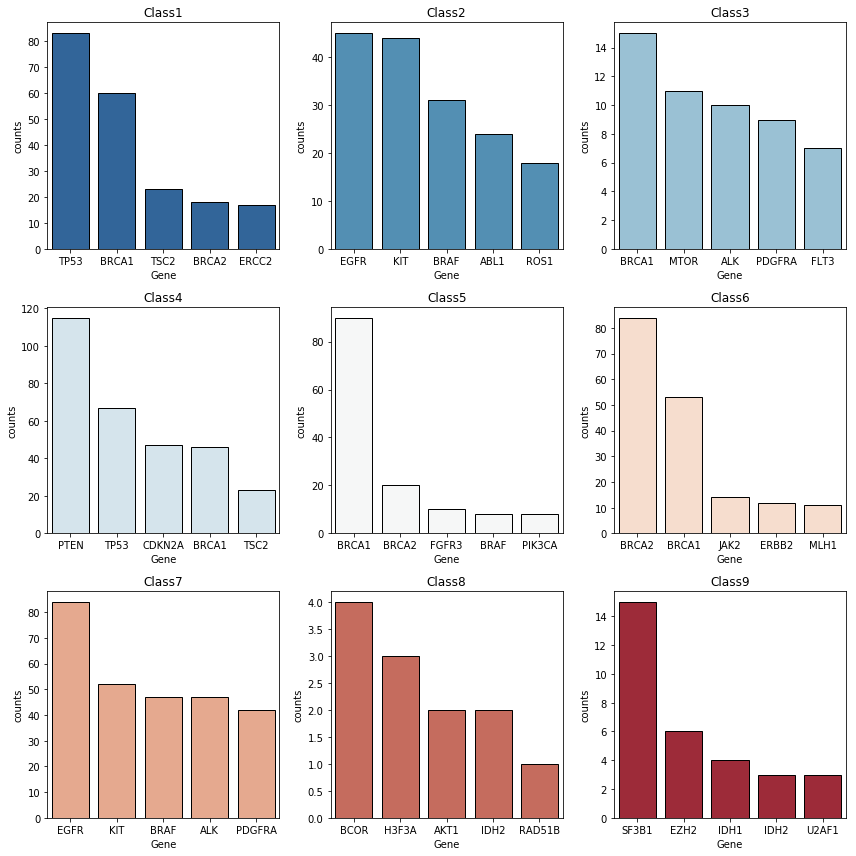

In [181]:
palette=sns.color_palette('RdBu',9)
fig,axes=plt.subplots(3,3,figsize=(12,12))
top5_dict={}
for i in range(9):
    nrow=i//3
    ncol=i%3
    train_df_sub=train_df.query('Class=="{}"'.format(i+1))
    train_df_sub2=train_df_sub.Gene.value_counts().to_frame().reset_index().rename(columns={'Gene':'counts','index':'Gene'})[:5]
    top5_dict[i+1]=train_df_sub2.Gene.values
    sns.barplot(x='Gene',y='counts',data=train_df_sub2,color=palette[8-i],ax=axes[nrow][ncol],edgecolor='black')
    axes[nrow][ncol].set_title('Class{}'.format(i+1))
plt.tight_layout()

In [182]:
top5_df=pd.DataFrame.from_dict(top5_dict)
top5_df.columns=['Class{}'.format(i) for i in range(1,10)]
top5_df

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9
0,TP53,EGFR,BRCA1,PTEN,BRCA1,BRCA2,EGFR,BCOR,SF3B1
1,BRCA1,KIT,MTOR,TP53,BRCA2,BRCA1,KIT,H3F3A,EZH2
2,TSC2,BRAF,ALK,CDKN2A,FGFR3,JAK2,BRAF,AKT1,IDH1
3,BRCA2,ABL1,PDGFRA,BRCA1,BRAF,ERBB2,ALK,IDH2,IDH2
4,ERCC2,ROS1,FLT3,TSC2,PIK3CA,MLH1,PDGFRA,RAD51B,U2AF1


In [200]:
## The top 50 most frequently mutated genes in the entire training dataset
top50=train_gene_freq.Gene[:50].values

In [201]:
distinct_gene_dict=defaultdict(list)
for i in range(9):
    top5=top5_df.iloc[:,i].values
    for j in top5:
        if j not in top50:
            distinct_gene_dict['Class{}'.format(i+1)].append(j)
distinct_gene_dict

defaultdict(list,
            {'Class8': ['BCOR', 'H3F3A', 'IDH2', 'RAD51B'],
             'Class9': ['SF3B1', 'EZH2', 'IDH1', 'IDH2', 'U2AF1']})

Except for `Class8` and `Class9`, the top 5 most frequently mutated genes in each class all fall into the top 50 most frequently mutated genes in the entire training dataset, which may be due to the small sample size in `Class8` and `Class9`. Altogether, there is no significant difference in most frequently mutated genes in each class.

In [209]:
# train_df.to_csv(os.path.join(base_dir,'pre/train_df_1.csv'),index=False)
# test_df.to_csv(os.path.join(base_dir,'pre/test_df_1.csv'),index=False)

<a id='Part1.6_link'></a>
## 1.6 Keywords

<a id='Part1.6.1_link'></a>
### 1.6.1 Extract keywords using `gensim.summarization.keywords` for training and testing datasets

In [217]:
train_keyword_composite=train_df.Text.apply(lambda x:keywords(x,words=10, scores=False, split=True, lemmatize=True))

In [246]:
train_keyword_df=train_keyword_composite.to_frame().rename(columns={'Text':'composite'})
for i in range(10):
    train_keyword_df['Keyword{}'.format(i+1)]=train_keyword_df.composite.apply(lambda x:x[i] if i<len(x) else np.nan)
train_keyword_df.drop(['composite'],axis=1,inplace=True)
train_keyword_df.head()

,Keyword1,Keyword2,Keyword3,Keyword4,Keyword5,Keyword6,Keyword7,Keyword8,Keyword9,Keyword10
0,cdk,cell,ets,proteins,cyclins,gene,figs,expressing,case,interacting
1,mutational,cbl,cells,difference,egfr,sample,ubiquitinated,primer,dna,activities
2,mutational,cbl,cells,difference,egfr,sample,ubiquitinated,primer,dna,activities
3,cbl_i,cell,mutated,figure,case,analysis,mpn,sequenced,indicate,aupd
4,mutated,cbl,proteins,cancers,cell,activate,bind,method,structural,state


In [248]:
# train_keyword_df.to_csv(os.path.join(base_dir,'pre/train_keyword_df.csv'),index=False)

In [249]:
test_keyword_composite=test_df.Text.apply(lambda x:keywords(x,words=10, scores=False, split=True, lemmatize=True))

In [250]:
test_keyword_df=test_keyword_composite.to_frame().rename(columns={'Text':'composite'})
for i in range(10):
    test_keyword_df['Keyword{}'.format(i+1)]=test_keyword_df.composite.apply(lambda x:x[i] if i<len(x) else np.nan)
test_keyword_df.drop(['composite'],axis=1,inplace=True)
test_keyword_df.head()

,Keyword1,Keyword2,Keyword3,Keyword4,Keyword5,Keyword6,Keyword7,Keyword8,Keyword9,Keyword10
0,mutational,cells,egfrs,fig,jak,patient,tumor,activation,exons,mutants
1,wwp,lats,cells,mutational,controlled,proteins,fig,expressed,cancer,pcr
2,cell,erbb,vegf,activates,tumors,cancers,protein,studying,svegfr,figs
3,cell,tumors,kinases,alk,proteins,cyclin,figure,activities,expressed,include
4,cells,egfr,proteins,cbl,mutated,signal,expresses,tumors,prb,included


In [251]:
# test_keyword_df.to_csv(os.path.join(base_dir, 'pre/test_keyword_df.csv'),index=False)

In [301]:
# a=train_keyword_df.apply(lambda x:[i for i in x],axis=1)
# len(a.values.sum())
train_keyword_count_df=pd.DataFrame.from_dict(Counter(train_keyword_composite.sum()),orient='index').reset_index().rename(columns={'index':'Gene',0:'counts'}).sort_values(by=['counts'],ascending=False)
print('Number of unique keywords in training dataset: {}'.format(len(train_keyword_count_df)))
train_keyword_count_df['freq(%)']=np.round(train_keyword_count_df.counts/len(train_df)*100,2)
train_keyword_count_df.head()
# train_keyword_count_df.to_csv(os.path.join(base_dir,'pre/train_keyword_count_df.csv'),index=False)

Number of unique keywords in training dataset: 2032


,Gene,counts,freq(%)
12,cells,1434,43.24
1,cell,993,29.95
3,proteins,948,28.59
10,mutational,867,26.15
21,mutated,859,25.90


In [300]:
test_keyword_count_df=pd.DataFrame.from_dict(Counter(test_keyword_composite.sum()),orient='index').reset_index().rename(columns={'index':'Gene',0:'counts'}).sort_values(by=['counts'],ascending=False)
print('Number of unique keywords in testing dataset: {}'.format(len(test_keyword_count_df)))
test_keyword_count_df['freq(%)']=np.round(test_keyword_count_df.counts/len(test_df)*100,2)
test_keyword_count_df.head()
# test_keyword_count_df.to_csv(os.path.join(base_dir,'pre/test_keyword_count_df.csv'),index=False)

Number of unique keywords in testing dataset: 2410


,Gene,counts,freq(%)
1,cells,2995,52.85
17,cell,2163,38.17
35,mutated,1780,31.41
13,proteins,1732,30.56
0,mutational,1570,27.70


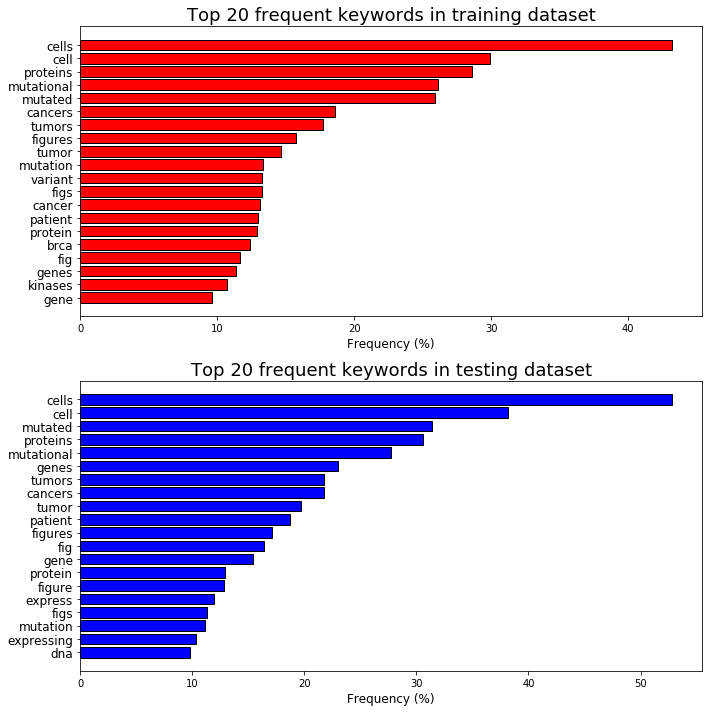

In [451]:
fig,axes=plt.subplots(2,1,figsize=(10,10))
axes[0].barh(np.arange(20),train_keyword_count_df['freq(%)'][:20],edgecolor='black',color='red')
axes[1].barh(np.arange(20),test_keyword_count_df['freq(%)'][:20],edgecolor='black',color='blue')

axes[0].set_yticks(np.arange(20))
axes[0].set_yticklabels(train_keyword_count_df.Gene[:20],fontsize=12)
axes[0].invert_yaxis()
axes[0].set_title('Top 20 frequent keywords in training dataset',fontsize=18)
axes[0].set_xlabel('Frequency (%)',fontsize=12)
axes[1].set_yticks(np.arange(20))
axes[1].set_yticklabels(test_keyword_count_df.Gene[:20],fontsize=12)
axes[1].invert_yaxis()
axes[1].set_title('Top 20 frequent keywords in testing dataset',fontsize=18)
axes[1].set_xlabel('Frequency (%)',fontsize=12)
plt.tight_layout()

In [292]:
train_test_keyword_intersect=np.intersect1d(train_keyword_count_df.Gene,test_keyword_count_df.Gene)
print('Number of unique keywords in both train_df and test_df: {}'.format(len(train_test_keyword_intersect)))

Number of unique keywords in both train_df and test_df: 1596


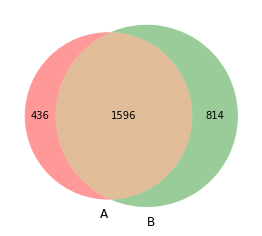

In [295]:
venn2([set(train_keyword_count_df.Gene.values), set(test_keyword_count_df.Gene.values)])

**Summary of keywords:**
1. Based on venn diagram, the majority of the keywords in training and testing datasets overlap with each other, suggesting there is no significant bias in lexical context between the two datasets.
2. Certain keywords `cells`, `cell`, `mutational`, `mutated`, `proteins` appear very frequently in texts, and may provide limited information for classification. These highly frequent (custom) words need to be removed before training the model.

<a id='Part1.6.2_link'></a>
### 1.6.2 Extract keywords from each class

In [327]:
train_keyword_df2 = pd.DataFrame({'keywords': train_keyword_composite.values, 'Class':train_df.Class.values})
train_keyword_df2 = train_keyword_df2.groupby(['Class']).sum()
train_keyword_df2

,keywords
Class,
1,"[cdk, cell, ets, proteins, cyclins, gene, figs..."
2,"[mutational, cbl, cells, difference, egfr, sam..."
3,"[cbl_i, cell, mutated, figure, case, analysis,..."
4,"[mutated, cbl, proteins, cancers, cell, activa..."
5,"[mutated, cbl, proteins, cancers, cell, activa..."
6,"[mutational, cbl, cells, proteins, active, can..."
7,"[mutational, tert, tumors, cancers, cells, mel..."
8,"[mutate, gene, cell, hotspot, sequenced, figur..."
9,"[mutational, spliced, figures, sequencers, gen..."


In [372]:
def normalize_row(x):
    '''Normalize the keyword counts against the total number of descriptions in each class'''
    genes,repetition=zip(*x.counter10)
    freqs=[np.round(r/x.class_counts*100,2) for r in repetition]
    return list(zip(genes,freqs))

In [376]:
train_keyword_df2['counter']=train_keyword_df2.keywords.apply(lambda x:Counter(x).most_common())
train_keyword_df2['counter10']=train_keyword_df2.counter.apply(lambda x:x[:10])
train_keyword_df2['class_counts']=train_class.counts.values
train_keyword_df2['counter10_freq']=train_keyword_df2.apply(lambda x:normalize_row(x),axis=1)
train_keyword_df2

,keywords,counter,counter10,class_counts,counter10_freq
Class,,,,,
1,"[cdk, cell, ets, proteins, cyclins, gene, figs...","[(proteins, 237), (cells, 228), (mutated, 137)...","[(proteins, 237), (cells, 228), (mutated, 137)...",566,"[(proteins, 41.87), (cells, 40.28), (mutated, ..."
2,"[mutational, cbl, cells, difference, egfr, sam...","[(cells, 177), (patient, 146), (cell, 143), (m...","[(cells, 177), (patient, 146), (cell, 143), (m...",452,"[(cells, 39.16), (patient, 32.3), (cell, 31.64..."
3,"[cbl_i, cell, mutated, figure, case, analysis,...","[(cell, 39), (cells, 39), (mutated, 31), (muta...","[(cell, 39), (cells, 39), (mutated, 31), (muta...",89,"[(cell, 43.82), (cells, 43.82), (mutated, 34.8..."
4,"[mutated, cbl, proteins, cancers, cell, activa...","[(cells, 349), (proteins, 263), (cell, 204), (...","[(cells, 349), (proteins, 263), (cell, 204), (...",686,"[(cells, 50.87), (proteins, 38.34), (cell, 29...."
5,"[mutated, cbl, proteins, cancers, cell, activa...","[(variant, 121), (brca, 110), (proteins, 104),...","[(variant, 121), (brca, 110), (proteins, 104),...",242,"[(variant, 50.0), (brca, 45.45), (proteins, 42..."
6,"[mutational, cbl, cells, proteins, active, can...","[(brca, 139), (variant, 103), (mutational, 89)...","[(brca, 139), (variant, 103), (mutational, 89)...",273,"[(brca, 50.92), (variant, 37.73), (mutational,..."
7,"[mutational, tert, tumors, cancers, cells, mel...","[(cells, 496), (cell, 360), (mutated, 294), (m...","[(cells, 496), (cell, 360), (mutated, 294), (m...",952,"[(cells, 52.1), (cell, 37.82), (mutated, 30.88..."
8,"[mutate, gene, cell, hotspot, sequenced, figur...","[(cell, 10), (genes, 9), (tumor, 7), (figures,...","[(cell, 10), (genes, 9), (tumor, 7), (figures,...",19,"[(cell, 52.63), (genes, 47.37), (tumor, 36.84)..."
9,"[mutational, spliced, figures, sequencers, gen...","[(cells, 17), (cell, 15), (mutational, 14), (f...","[(cells, 17), (cell, 15), (mutational, 14), (f...",37,"[(cells, 45.95), (cell, 40.54), (mutational, 3..."


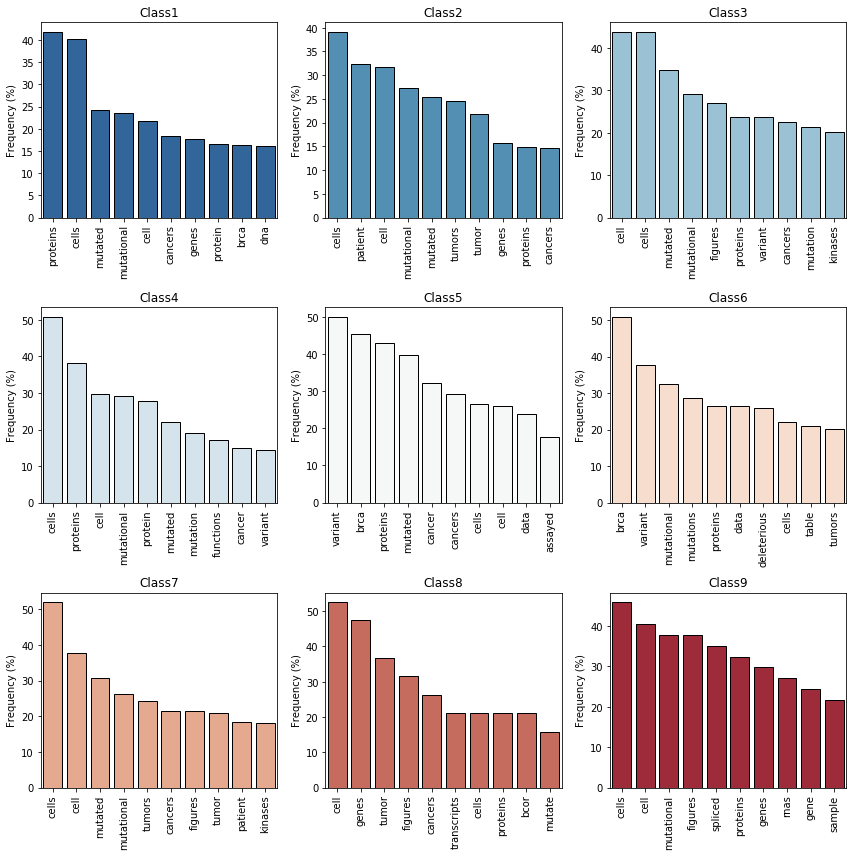

In [452]:
## Plot top 10 keywords for each class
palette=sns.color_palette('RdBu',9)
fig,axes=plt.subplots(3,3,figsize=(12,12))
top5_dict={}
for i in range(9):
    nrow=i//3
    ncol=i%3
    genes,counts=zip(*train_keyword_df2.counter10_freq.loc[i+1])
    sns.barplot(x=np.array(genes),y=np.array(counts),color=palette[8-i],ax=axes[nrow][ncol],edgecolor='black')
    axes[nrow][ncol].set_title('Class{}'.format(i+1))
    axes[nrow][ncol].set_xticks(np.arange(10))
    axes[nrow][ncol].set_xticklabels(np.array(genes),rotation=90)
    axes[nrow][ncol].set_ylabel('Frequency (%)')
plt.tight_layout()

Based on the top10 keywords from each class, we can see that custom words `cells`, `cell`, `mutational`, `mutated`, `proteins` account for a large percentage. These further suggest that custom words may mask some distinct features of each class and need to be removed before moving forward with classification. 

<br>In addition, certain keywords show especially high frequency in some classes. `brca` is the most frequent keyword in `Class6` and the second most frequent keyword in `Class5`.

<br>To better visualize the relative percentage of the top10 keywords in each class, next we will normalize the counts of each keyword in each class against the sum of counts of all top10 keywords in each specific class to evaluate the relative weight of different keywords.

In [408]:
def normalize_row2(x):
    '''Normalize the keyword counts against the total number of top10 keyword counts in each class;
       The purpose is to evaluate the relative percentage of the top10 keyword counts in each class'''
    genes,repetition=zip(*x.counter10)
    t=sum(repetition)
    freqs=[np.round(r/t*100,2) for r in repetition]
    return list(zip(genes,freqs))

In [412]:
train_keyword_df2['counter10_freq2']=train_keyword_df2.apply(lambda x:normalize_row2(x),axis=1)
train_keyword_df2.head()

,keywords,counter,counter10,class_counts,counter10_freq,counter10_freq2
Class,,,,,,
1,"[cdk, cell, ets, proteins, cyclins, gene, figs...","[(proteins, 237), (cells, 228), (mutated, 137)...","[(proteins, 237), (cells, 228), (mutated, 137)...",566,"[(proteins, 41.87), (cells, 40.28), (mutated, ...","[(proteins, 17.7), (cells, 17.03), (mutated, 1..."
2,"[mutational, cbl, cells, difference, egfr, sam...","[(cells, 177), (patient, 146), (cell, 143), (m...","[(cells, 177), (patient, 146), (cell, 143), (m...",452,"[(cells, 39.16), (patient, 32.3), (cell, 31.64...","[(cells, 15.83), (patient, 13.06), (cell, 12.7..."
3,"[cbl_i, cell, mutated, figure, case, analysis,...","[(cell, 39), (cells, 39), (mutated, 31), (muta...","[(cell, 39), (cells, 39), (mutated, 31), (muta...",89,"[(cell, 43.82), (cells, 43.82), (mutated, 34.8...","[(cell, 15.12), (cells, 15.12), (mutated, 12.0..."
4,"[mutated, cbl, proteins, cancers, cell, activa...","[(cells, 349), (proteins, 263), (cell, 204), (...","[(cells, 349), (proteins, 263), (cell, 204), (...",686,"[(cells, 50.87), (proteins, 38.34), (cell, 29....","[(cells, 19.31), (proteins, 14.55), (cell, 11...."
5,"[mutated, cbl, proteins, cancers, cell, activa...","[(variant, 121), (brca, 110), (proteins, 104),...","[(variant, 121), (brca, 110), (proteins, 104),...",242,"[(variant, 50.0), (brca, 45.45), (proteins, 42...","[(variant, 14.98), (brca, 13.61), (proteins, 1..."


In [474]:
# train_keyword_df2.to_csv(os.path.join(base_dir,'pre/train_keyword_df2.csv'))
# train_keyword_df2=pd.read_csv(os.path.join(base_dir,'pre/train_keyword_df2.csv'),index_col='Class',converters={"keywords":literal_eval,"counter":literal_eval,"counter10":literal_eval,"counter10_freq":literal_eval,"counter10_freq2":literal_eval})
# train_keyword_df2.head()

In [471]:
train_keyword_df2_freq10=pd.DataFrame.from_records(train_keyword_df2.counter10_freq2.values.tolist()).set_index(train_keyword_df2.index)
train_keyword_df2_freq10

,0,1,2,3,4,5,6,7,8,9
Class,,,,,,,,,,
1,"(proteins, 17.7)","(cells, 17.03)","(mutated, 10.23)","(mutational, 9.93)","(cell, 9.19)","(cancers, 7.77)","(genes, 7.47)","(protein, 7.02)","(brca, 6.87)","(dna, 6.8)"
2,"(cells, 15.83)","(patient, 13.06)","(cell, 12.79)","(mutational, 11.0)","(mutated, 10.29)","(tumors, 9.93)","(tumor, 8.86)","(genes, 6.35)","(proteins, 5.99)","(cancers, 5.9)"
3,"(cell, 15.12)","(cells, 15.12)","(mutated, 12.02)","(mutational, 10.08)","(figures, 9.3)","(proteins, 8.14)","(variant, 8.14)","(cancers, 7.75)","(mutation, 7.36)","(kinases, 6.98)"
4,"(cells, 19.31)","(proteins, 14.55)","(cell, 11.29)","(mutational, 11.12)","(protein, 10.51)","(mutated, 8.36)","(mutation, 7.19)","(functions, 6.47)","(cancer, 5.7)","(variant, 5.48)"
5,"(variant, 14.98)","(brca, 13.61)","(proteins, 12.87)","(mutated, 11.88)","(cancer, 9.65)","(cancers, 8.79)","(cells, 7.92)","(cell, 7.8)","(data, 7.18)","(assayed, 5.32)"
6,"(brca, 17.46)","(variant, 12.94)","(mutational, 11.18)","(mutations, 9.8)","(proteins, 9.05)","(data, 9.05)","(deleterious, 8.92)","(cells, 7.54)","(table, 7.16)","(tumors, 6.91)"
7,"(cells, 19.17)","(cell, 13.92)","(mutated, 11.36)","(mutational, 9.66)","(tumors, 8.89)","(cancers, 7.92)","(figures, 7.89)","(tumor, 7.69)","(patient, 6.8)","(kinases, 6.69)"
8,"(cell, 17.86)","(genes, 16.07)","(tumor, 12.5)","(figures, 10.71)","(cancers, 8.93)","(transcripts, 7.14)","(cells, 7.14)","(proteins, 7.14)","(bcor, 7.14)","(mutate, 5.36)"
9,"(cells, 13.82)","(cell, 12.2)","(mutational, 11.38)","(figures, 11.38)","(spliced, 10.57)","(proteins, 9.76)","(genes, 8.94)","(rnas, 8.13)","(gene, 7.32)","(sample, 6.5)"


In [472]:
keywords10_all=[x for x in train_keyword_df2_freq10.sum().sum() if isinstance(x,str)]
keywords10_all_unique=list(set(keywords10_all))
# len(keywords10_all_unique)
## keywords are re-organized to reflect the semantic meaning of each keyword
keywords10_all_unique=['deleterious','mutated','mutation','mutational','mutations','mutate','cancer','cancers','tumor','tumors',
                       'brca','bcor','rnas','kinases','dna','proteins','protein','cells','cell','genes','gene','transcripts','spliced','variant','patient','functions',
                        'assayed','figures','data','sample','table']
#cm = plt.get_cmap('Blues_r', len(keywords10_all_unique))
cm = plt.get_cmap('RdBu', len(keywords10_all_unique))
colors = {k:cm(keywords10_all_unique.index(k)) for k in keywords10_all_unique}   ## 31
print(len(colors))

31


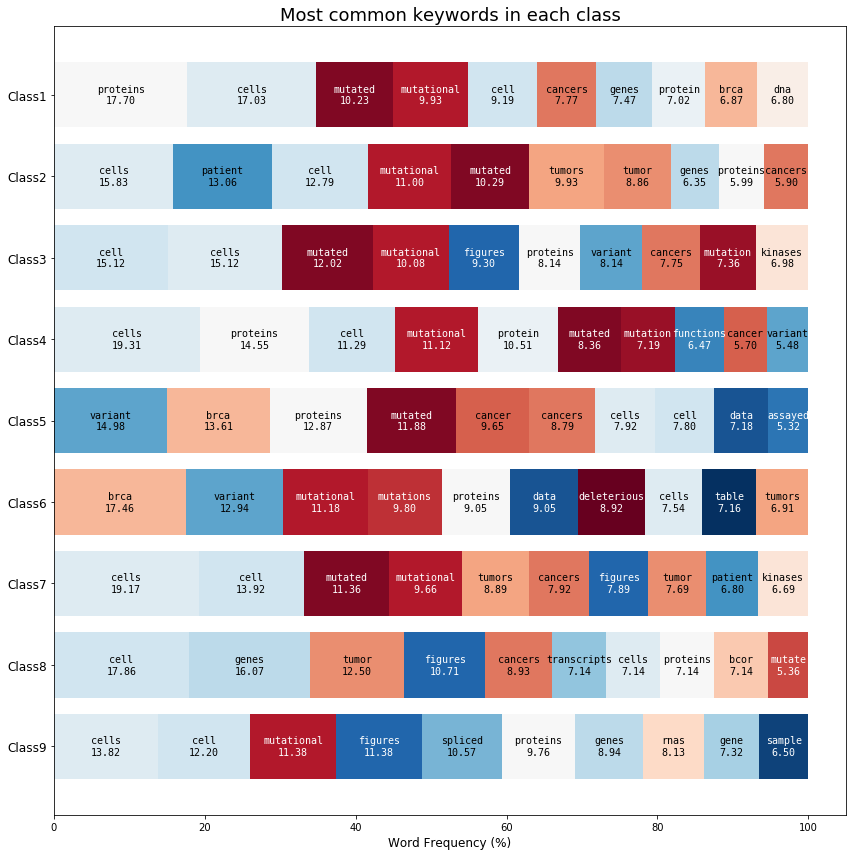

In [473]:
fig, ax = plt.subplots(figsize=(12,12))

offset = np.zeros(9)
for r in train_keyword_df2_freq10.iteritems():
    label, repetition = zip(*r[1])
    ax.barh(range(len(train_keyword_df2_freq10)), repetition, left=offset, color=[colors[l] for l in label])
    offset += repetition
    
ax.set_yticks(np.arange(len(train_keyword_df2_freq10)))
ax.set_yticklabels(np.array(['Class{}'.format(i) for i in train_keyword_df2_freq10.index]),fontsize=12)
ax.invert_yaxis()

# annotate words
offset_x = np.zeros(9) 
for idx, a in enumerate(ax.patches):
    fc = 'k' if sum(a.get_fc()) > 2.5 else 'w'
    ax.text(offset_x[idx%9] + a.get_width()/2, a.get_y() + a.get_height()/2, 
            '{}\n{:.2f}'.format(keywords10_all[idx], a.get_width()), 
            ha='center', va='center', color=fc, fontsize=10, family='monospace')
    offset_x[idx%9] += a.get_width()
    
ax.set_title('Most common keywords in each class',fontsize=18)
ax.set_xlabel('Word Frequency (%)',fontsize=12)

plt.tight_layout()
plt.show()

The color of each keyword relatively reflects its semantic meaning. Keywords such as `deleterious`, `mutated` can relatively imply cancer malignancy and are plotted in 'red' color, while keywords such as `figures`, `data`, `sample`, `table` are just common words in academic literature without any semantic meaning to tumor classification and are plotted in 'blue' color.

Most of the top keywords in each class are relatively 'neutral' and cannot provide meaningful information to classification. However, `Class5` and `Class6` are slightly different from the other classes due to top ranking of keywords `brca` and `deleterious`. Altogether, these suggest that we need to remove the custom words before classification.

<a id='Part1.6.3_link'></a>
### 1.6.3 Visualize frequent words in each category after removing custom words

Instead of extracting keywords from each description, here I combine all the descriptions from each class and extract most frequent words based on word counts. In addition, selected custom_words, stop_words and punctuation are removed and lemmatization is applied.

In [7]:
def preprocess(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

In [8]:
train_df['text_clean'] = preprocess(train_df.Text)
test_df['text_clean'] = preprocess(test_df.Text)

In [9]:
custom_words = ["fig", "figure", "et", "al", "al.", "also",
                "data", "analyze", "study", "table", "using",
                "method", "result", "conclusion", "author", 
                "find", "found", "show", '"', "’", "“", "”", 'analysis','analyses','analyzed','results','figures'
                "assayed", "assay", "assays","figures", "figure","data", "sample","samples","table","tables",
                'proteins','protein','cells','cell','genes','gene',
                'mutated','mutation','mutational','mutations','mutate','mutant','mutants',
                'cancer','cancers','tumor','tumors','variant','variants']
stop_word1 = gensim.parsing.preprocessing.STOPWORDS   ## 337
stop_word2 = nltk.corpus.stopwords.words('english')   ## 179
stop_words = set(list(stop_word1)+stop_word2+custom_words)   ## 433

In [630]:
wordnet_lemmatizer = WordNetLemmatizer()
class_corpus=train_df.groupby(['Class']).apply(lambda x:x.text_clean.str.cat())
class_corpus=class_corpus.apply(lambda x:Counter([wordnet_lemmatizer.lemmatize(w) for w in word_tokenize(x) if w.lower() not in stop_words and not w.isdigit() and len(w)>1]))

In [631]:
train_class_corpus = pd.DataFrame({'counter': class_corpus.values},index=class_corpus.index)
train_class_corpus['counter']=train_class_corpus.counter.apply(lambda x:Counter(x).most_common())
train_class_corpus['counter10']=train_class_corpus.counter.apply(lambda x:x[:10])
train_class_corpus['class_counts']=train_class.counts.values
train_class_corpus['counter10_freq']=train_class_corpus.apply(lambda x:normalize_row(x),axis=1)
train_class_corpus

,counter,counter10,class_counts,counter10_freq
Class,,,,
1,"[(p53, 19496), (type, 17112), (DNA, 15418), (d...","[(p53, 19496), (type, 17112), (DNA, 15418), (d...",566,"[(p53, 3444.52), (type, 3023.32), (DNA, 2724.0..."
2,"[(patient, 23148), (kinase, 14000), (EGFR, 118...","[(patient, 23148), (kinase, 14000), (EGFR, 118...",452,"[(patient, 5121.24), (kinase, 3097.35), (EGFR,..."
3,"[(BRCA1, 4032), (ALK, 2075), (activity, 1941),...","[(BRCA1, 4032), (ALK, 2075), (activity, 1941),...",89,"[(BRCA1, 4530.34), (ALK, 2331.46), (activity, ..."
4,"[(PTEN, 25233), (activity, 23000), (type, 1816...","[(PTEN, 25233), (activity, 23000), (type, 1816...",686,"[(PTEN, 3678.28), (activity, 3352.77), (type, ..."
5,"[(BRCA1, 13505), (domain, 6191), (type, 5616),...","[(BRCA1, 13505), (domain, 6191), (type, 5616),...",242,"[(BRCA1, 5580.58), (domain, 2558.26), (type, 2..."
6,"[(BRCA1, 13034), (domain, 6342), (deleterious,...","[(BRCA1, 13034), (domain, 6342), (deleterious,...",273,"[(BRCA1, 4774.36), (domain, 2323.08), (deleter..."
7,"[(patient, 50204), (kinase, 38996), (EGFR, 371...","[(patient, 50204), (kinase, 38996), (EGFR, 371...",952,"[(patient, 5273.53), (kinase, 4096.22), (EGFR,..."
8,"[(expression, 835), (IDH1, 555), (type, 534), ...","[(expression, 835), (IDH1, 555), (type, 534), ...",19,"[(expression, 4394.74), (IDH1, 2921.05), (type..."
9,"[(SF3B1, 2490), (splicing, 2073), (IDH1, 1862)...","[(SF3B1, 2490), (splicing, 2073), (IDH1, 1862)...",37,"[(SF3B1, 6729.73), (splicing, 5602.7), (IDH1, ..."


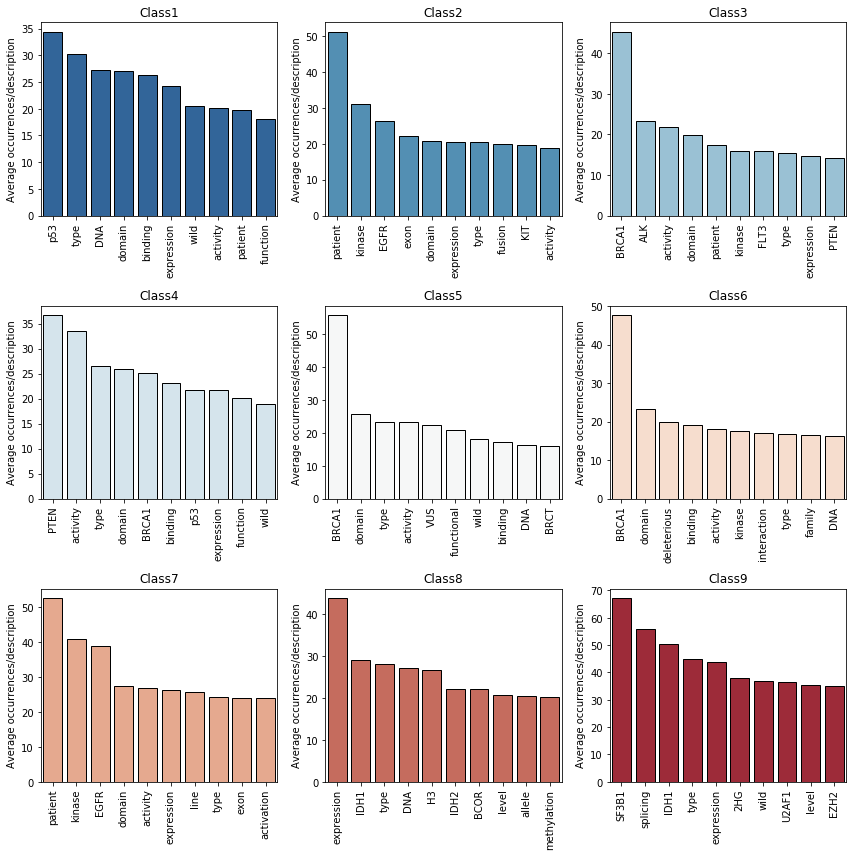

In [632]:
## Plot top 10 keywords for each class
palette=sns.color_palette('RdBu',9)
fig,axes=plt.subplots(3,3,figsize=(12,12))
top5_dict={}
for i in range(9):
    nrow=i//3
    ncol=i%3
    genes,counts=zip(*train_class_corpus.counter10_freq.loc[i+1])
    sns.barplot(x=np.array(genes),y=np.array(counts)/100,color=palette[8-i],ax=axes[nrow][ncol],edgecolor='black')
    axes[nrow][ncol].set_title('Class{}'.format(i+1))
    axes[nrow][ncol].set_xticks(np.arange(10))
    axes[nrow][ncol].set_xticklabels(np.array(genes),rotation=90)
    axes[nrow][ncol].set_ylabel('Average occurrences/description')
plt.tight_layout()

In [633]:
train_class_corpus['counter10_freq2']=train_class_corpus.apply(lambda x:normalize_row2(x),axis=1)
train_class_corpus.head()

,counter,counter10,class_counts,counter10_freq,counter10_freq2
Class,,,,,
1,"[(p53, 19496), (type, 17112), (DNA, 15418), (d...","[(p53, 19496), (type, 17112), (DNA, 15418), (d...",566,"[(p53, 3444.52), (type, 3023.32), (DNA, 2724.0...","[(p53, 13.88), (type, 12.19), (DNA, 10.98), (d..."
2,"[(patient, 23148), (kinase, 14000), (EGFR, 118...","[(patient, 23148), (kinase, 14000), (EGFR, 118...",452,"[(patient, 5121.24), (kinase, 3097.35), (EGFR,...","[(patient, 20.44), (kinase, 12.36), (EGFR, 10...."
3,"[(BRCA1, 4032), (ALK, 2075), (activity, 1941),...","[(BRCA1, 4032), (ALK, 2075), (activity, 1941),...",89,"[(BRCA1, 4530.34), (ALK, 2331.46), (activity, ...","[(BRCA1, 22.24), (ALK, 11.44), (activity, 10.7..."
4,"[(PTEN, 25233), (activity, 23000), (type, 1816...","[(PTEN, 25233), (activity, 23000), (type, 1816...",686,"[(PTEN, 3678.28), (activity, 3352.77), (type, ...","[(PTEN, 14.5), (activity, 13.22), (type, 10.44..."
5,"[(BRCA1, 13505), (domain, 6191), (type, 5616),...","[(BRCA1, 13505), (domain, 6191), (type, 5616),...",242,"[(BRCA1, 5580.58), (domain, 2558.26), (type, 2...","[(BRCA1, 23.41), (domain, 10.73), (type, 9.73)..."


In [635]:
# train_class_corpus.to_csv(os.path.join(base_dir,'pre/train_class_corpus_df.csv'))
# train_class_corpus=pd.read_csv(os.path.join(base_dir,'pre/train_class_corpus_df.csv'),index_col='Class',converters={"counter":literal_eval,"counter10":literal_eval,"counter10_freq":literal_eval,"counter10_freq2":literal_eval})
# train_class_corpus.head()

In [636]:
train_class_corpus_freq10=pd.DataFrame.from_records(train_class_corpus.counter10_freq2.values.tolist()).set_index(train_class_corpus.index)
train_class_corpus_freq10

,0,1,2,3,4,5,6,7,8,9
Class,,,,,,,,,,
1,"(p53, 13.88)","(type, 12.19)","(DNA, 10.98)","(domain, 10.88)","(binding, 10.62)","(expression, 9.77)","(wild, 8.25)","(activity, 8.14)","(patient, 7.97)","(function, 7.32)"
2,"(patient, 20.44)","(kinase, 12.36)","(EGFR, 10.49)","(exon, 8.85)","(domain, 8.24)","(expression, 8.22)","(type, 8.13)","(fusion, 7.96)","(KIT, 7.81)","(activity, 7.51)"
3,"(BRCA1, 22.24)","(ALK, 11.44)","(activity, 10.7)","(domain, 9.79)","(patient, 8.56)","(kinase, 7.79)","(FLT3, 7.76)","(type, 7.57)","(expression, 7.18)","(PTEN, 6.96)"
4,"(PTEN, 14.5)","(activity, 13.22)","(type, 10.44)","(domain, 10.25)","(BRCA1, 9.9)","(binding, 9.12)","(p53, 8.58)","(expression, 8.58)","(function, 7.93)","(wild, 7.49)"
5,"(BRCA1, 23.41)","(domain, 10.73)","(type, 9.73)","(activity, 9.7)","(VUS, 9.33)","(functional, 8.71)","(wild, 7.6)","(binding, 7.19)","(DNA, 6.84)","(BRCT, 6.74)"
6,"(BRCA1, 22.49)","(domain, 10.94)","(deleterious, 9.43)","(binding, 8.96)","(activity, 8.54)","(kinase, 8.22)","(interaction, 8.02)","(type, 7.94)","(family, 7.83)","(DNA, 7.64)"
7,"(patient, 16.91)","(kinase, 13.14)","(EGFR, 12.52)","(domain, 8.83)","(activity, 8.67)","(expression, 8.42)","(line, 8.25)","(type, 7.82)","(exon, 7.74)","(activation, 7.69)"
8,"(expression, 16.85)","(IDH1, 11.2)","(type, 10.78)","(DNA, 10.43)","(H3, 10.21)","(IDH2, 8.52)","(BCOR, 8.46)","(level, 7.91)","(allele, 7.87)","(methylation, 7.77)"
9,"(SF3B1, 15.16)","(splicing, 12.62)","(IDH1, 11.33)","(type, 10.13)","(expression, 9.9)","(2HG, 8.54)","(wild, 8.28)","(U2AF1, 8.21)","(level, 7.97)","(EZH2, 7.86)"


In [647]:
freq10_all=[x for x in train_class_corpus_freq10.sum().sum() if isinstance(x,str)]
freq10_all_unique=list(set(freq10_all))
# len(keywords10_all_unique)
## keywords are re-organized to reflect the semantic meaning of each keyword
freq10_all_unique=['deleterious', 'p53', 'PTEN', 'EGFR','BRCA1', 'BCOR', 'ALK', 'KIT', 'VUS', 'BRCT', 'FLT3', 'IDH1', 'IDH2', 'EZH2', 'SF3B1', 'U2AF1', 
                   'DNA', 'H3', '2HG', 'methylation', 'splicing', 'exon', 'kinase', 'allele', 'fusion', 'binding', 'function', 'functional', 
                   'activity', 'activation', 'expression', 'interaction', 'patient', 'domain', 'level', 'family', 'line', 'wild', 'type']
#cm = plt.get_cmap('Blues_r', len(freq10_all_unique))
cm = plt.get_cmap('RdBu', len(freq10_all_unique))
colors = {k:cm(freq10_all_unique.index(k)) for k in freq10_all_unique}   ## 39
print(len(colors))

39


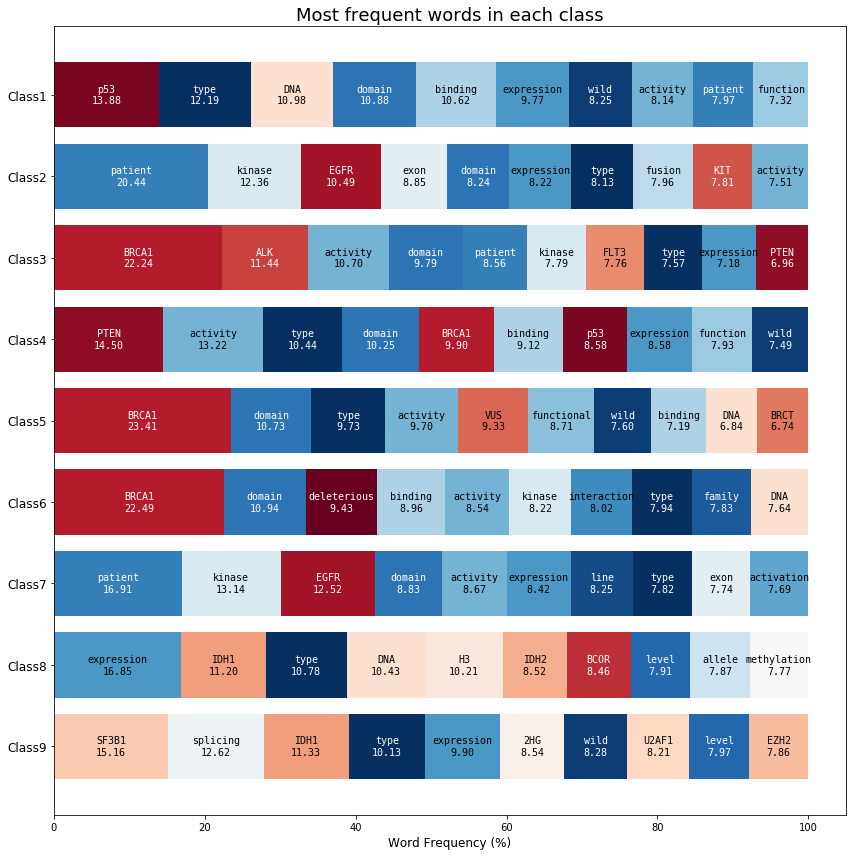

In [648]:
fig, ax = plt.subplots(figsize=(12,12))

offset = np.zeros(9)
for r in train_class_corpus_freq10.iteritems():
    label, repetition = zip(*r[1])
    ax.barh(range(len(train_class_corpus_freq10)), repetition, left=offset, color=[colors[l] for l in label])
    offset += repetition
    
ax.set_yticks(np.arange(len(train_class_corpus_freq10)))
ax.set_yticklabels(np.array(['Class{}'.format(i) for i in train_class_corpus_freq10.index]),fontsize=12)
ax.invert_yaxis()

# annotate words
offset_x = np.zeros(9) 
for idx, a in enumerate(ax.patches):
    fc = 'k' if sum(a.get_fc()) > 2.5 else 'w'
    ax.text(offset_x[idx%9] + a.get_width()/2, a.get_y() + a.get_height()/2, 
            '{}\n{:.2f}'.format(freq10_all[idx], a.get_width()), 
            ha='center', va='center', color=fc, fontsize=10, family='monospace')
    offset_x[idx%9] += a.get_width()
    
ax.set_title('Most frequent words in each class',fontsize=18)
ax.set_xlabel('Word Frequency (%)',fontsize=12)

plt.tight_layout()
plt.show()

The keyword is colored based on the importance of the semantic meaning in biological settings. Words represent genes such as `p53`, `BRCA1`, `BRCA2`, `EGFR`, `PTEN`, `IDH1`, `IDH2`, `EZH2`, `ALK`, `FLT3`, `KIT` are plotted in 'red' color, while words such as `line`, `family`, `level`, `Supplementary` are plotted in 'blue' color.

Based on the plot above, each class has very distinct genetic profiling based on the frequency of genes that appear in the text. 
1. `Class5` and `Class6` are characterized by `BRCA1` mutations. `Class5` has enrichment of `VUS` and `BRCT` mutations, and `Class6` is characterized by keyword `deleterious`, indicating higher tumor malignancy. 
2. `Class7` is the largest subgroup and is characterized with `EGFR` mutations with a lot of descriptions of clinical therapies based on the appearance of words `patient`, `inhibitor`. 
3. `Class8` and `Class9` are both very small datasets and enriched with `IDH1` and `IDH2` mutations. `Class8` may specialize in IDH1 and IDH2 mutant tumors based on the keywords `DNA` and `methylation`. `Class9` may specialize in tumors with splicing defects according to top mutated genes `SF3B1`, `U2AF1` and keywords `splicing`. 
4. `Class2` is similar to `Class7` with enrichment of `EGFR` mutations and `patient` as keyword. Both `Class2` and `Class7` are also highly enriched with `KIT` and `BRAF` mutations based on the mutant gene profiling. 
5. `Class4` is characterized by `PTEN`, `p53` and `BRCA1` mutations as they are both top mutated genes and occur frequently in text descriptions.
6. `Class1` is dominated by `p53` mutations as it is the most frequently mutated gene in tumor samples from this category and frequently appears in text descriptions. 

It is not clear the criterion that mutations are classified in this project. Based on the exploratory data analysis, genetic profiling plays an important role in classification.

<a id='Part1.6.4_link'></a>
### 1.6.4 Visualize frequent words in each category using WordCloud

In [649]:
whole_text_freq=class_corpus.sum()

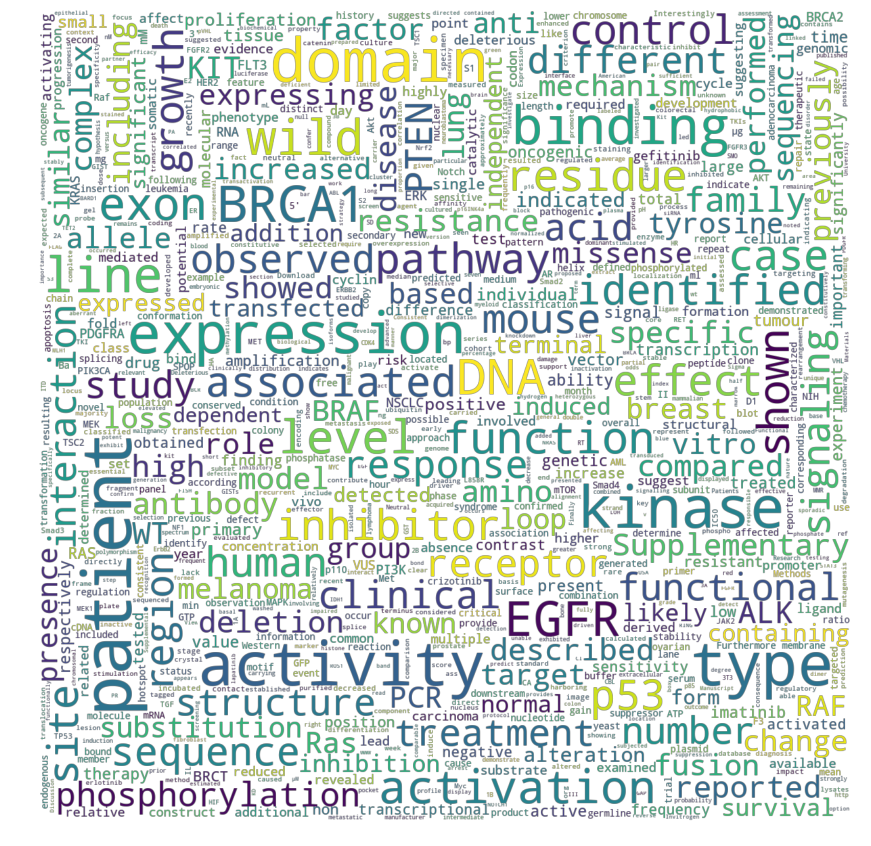

In [655]:
wc = WordCloud(max_font_size=100,
               min_font_size=8,
               max_words=2000,
               width=1200, 
               height=1200,
               relative_scaling=.52,
               background_color=None,
               mode="RGBA").generate_from_frequencies(whole_text_freq)
plt.figure(figsize=(12,12))
plt.axis("off")
plt.tight_layout()
plt.imshow(wc, interpolation="bilinear")
plt.savefig('wordcloud_total.png')

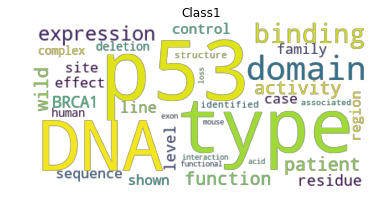

In [656]:
wc = WordCloud(max_font_size=100,
               min_font_size=8,
               max_words=500,
               relative_scaling=.52,
               background_color=None,
               mode="RGBA").generate_from_frequencies(class_corpus.values[0])
plt.figure()
plt.title('Class1')
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
# plt.savefig('wordcloud1.png')

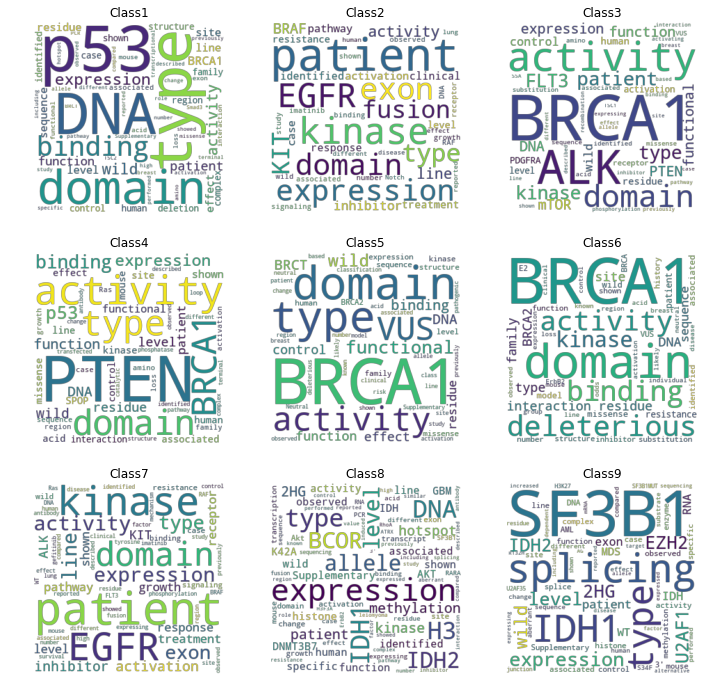

In [657]:
fig,axes=plt.subplots(3,3,figsize=(12,12))
for i in range(9):
    nrow=i//3
    ncol=i%3
    wc = WordCloud(max_font_size=100,
               min_font_size=8,
               max_words=500,
               width=300, 
               height=300,
               relative_scaling=.52,
               background_color=None,
               mode="RGBA").generate_from_frequencies(class_corpus.values[i])
    axes[nrow][ncol].set_title('Class{}'.format(i+1))
    axes[nrow][ncol].axis("off")
    axes[nrow][ncol].imshow(wc, interpolation="bilinear")
plt.savefig('wordcloud_all.png')